## Home Work 1.
In this home work I basically followed the process in the optional lecture [here](https://www.youtube.com/watch?v=iRunifGSHFc&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=5&pp=iAQB). There are certain things I could approached differently but they will skew the provided answers.

In [1]:
import pandas as pd
from pathlib import Path

data_dir = "/home/fini/github-projects/mlops/data/raw_data"

In [2]:
def add_trip_duration(
    df, pick_up="lpep_dropoff_datetime", drop_off="lpep_pickup_datetime"
):
    df[pick_up] = pd.to_datetime(df[pick_up])
    df[drop_off] = pd.to_datetime(df[drop_off])
    df["duration"] = df[pick_up] - df[drop_off]
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    return df

## Assignment 1


In [3]:
yellow_taxi_20221 = pd.read_parquet(Path(data_dir) / "yellow_tripdata_2022-01.parquet")
yellow_taxi_20222 = pd.read_parquet(Path(data_dir) / "yellow_tripdata_2022-02.parquet")

In [4]:
yellow_taxi_20221.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.8,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.1,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0


1. Dimensions

In [5]:
yellow_taxi_20221.shape

(2463931, 19)

In [6]:
yellow_taxi_20221 = add_trip_duration(
    yellow_taxi_20221, pick_up="tpep_dropoff_datetime", drop_off="tpep_pickup_datetime"
)

In [7]:
yellow_taxi_20222 = add_trip_duration(
    yellow_taxi_20222, pick_up="tpep_dropoff_datetime", drop_off="tpep_pickup_datetime"
)

In [8]:
yellow_taxi_20222.shape

(2979431, 20)

2. Summary Statistics

In [9]:
yellow_taxi_20221["duration"].describe()

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
max      8.513183e+03
Name: duration, dtype: float64

<Axes: >

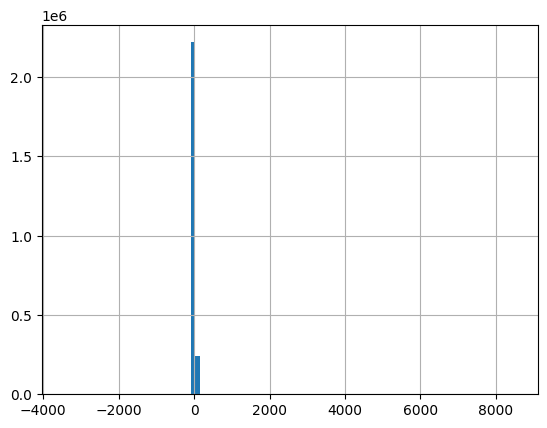

In [10]:
yellow_taxi_20221["duration"].hist(bins=100)

In [11]:
((yellow_taxi_20221["duration"] > 0) & (yellow_taxi_20221["duration"] <= 60)).mean()

0.9939377360810835

3. Outliers
Our approche here is to check the stats for the following percentiles and manually go through to see the cut offs.

<Axes: >

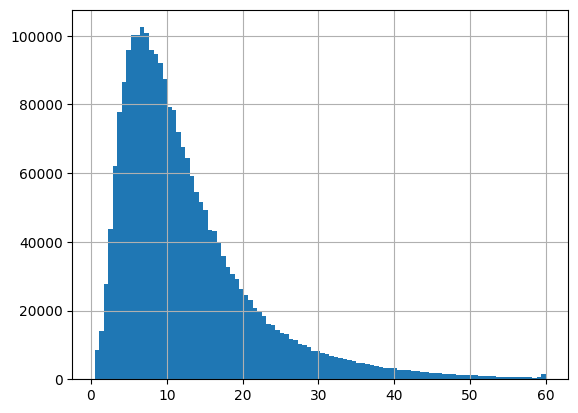

In [12]:
yellow_taxi_20221["duration"][
    ((yellow_taxi_20221["duration"] >0.5) & (yellow_taxi_20221["duration"] <= 60))
].hist(bins=100)

In [13]:
yellow_taxi_20221.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [14]:
for col in yellow_taxi_20221.drop(columns=["VendorID", "store_and_fwd_flag"]).columns:
    print(col)
    print(yellow_taxi_20221[col].describe(percentiles=[0.995, 0.998, 0.999]))

tpep_pickup_datetime
count                          2463931
mean     2022-01-17 01:19:51.689726208
min                2008-12-31 22:23:09
50%                2022-01-17 12:11:45
99.5%    2022-01-31 20:13:48.350000128
99.8%       2022-01-31 22:09:47.140000
99.9%    2022-01-31 22:54:48.070000128
max                2022-05-18 20:41:57
Name: tpep_pickup_datetime, dtype: object
tpep_dropoff_datetime
count                          2463931
mean     2022-01-17 01:34:04.421900544
min                2008-12-31 23:06:56
50%                2022-01-17 12:23:49
99.5%    2022-01-31 20:26:42.350000128
99.8%              2022-01-31 22:24:22
99.9%              2022-01-31 23:08:22
max                2022-05-18 20:47:45
Name: tpep_dropoff_datetime, dtype: object
passenger_count
count    2.392428e+06
mean     1.389453e+00
std      9.829686e-01
min      0.000000e+00
50%      1.000000e+00
99.5%    6.000000e+00
99.8%    6.000000e+00
99.9%    6.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: floa

Let's define the 99.9\% to be the outlier. We have the following columns with minimum and maximum extracted from above

| Column      | Min         | Max       |
| ----------- | ----------- | -----------
| fare_amount | 0 | 100
| extra |0|
| mta_tax |0|
| tip_amount |0 |20.5
| tolls_amount |0|
| total_amount |0 | 123
| congestion_surcharge |0|
| airport_fee |0|
| duration |0 | 77.7

In [15]:
# Columns with zero lower bound except duration
greater_than_zero_col = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "total_amount",
    "congestion_surcharge",
    "airport_fee",
    "duration",
]

# Those columns with an upper boundary
less_than_mask = (
    (yellow_taxi_20221["fare_amount"] <= 100)
    & (yellow_taxi_20221["tip_amount"] <= 20.5)
    & (yellow_taxi_20221["total_amount"] <= 123)
    & (yellow_taxi_20221["duration"] <= 123)
)
# Final mask
outlier_mask = less_than_mask.copy()
for col in greater_than_zero_col:
    if col == "duration":
        outlier_mask = outlier_mask & (yellow_taxi_20221[col] >= 1)
    else:
        outlier_mask = outlier_mask & (yellow_taxi_20221[col] >= 0)

In [16]:
outlier_mask.mean()

0.9534280789518862

4. Dimensionality of OHE

In [19]:
# categorical_cololumns = [
#     "store_and_fwd_flag",
#     "PULocationID",
#     "DOLocationID",
#     "payment_type",
# ]

In [20]:
train = yellow_taxi_20221[outlier_mask]

The notebook dies with the attemp to use all the columns  with the code

```python
enc.fit(train[categorical_cololumns])
train_ohe = enc.transform(train[categorical_cololumns])
```

So we will use on the columns shown in the optional video, that is the dura

In [44]:
train['PU_DO'] = train['PULocationID'].astype(str) + '_' + train['DOLocationID'].astype(str)

/tmp/ipykernel_132889/3311359884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['PU_DO'] = train['PULocationID'].astype(str) + '_' + train['DOLocationID'].astype(str)


In [35]:
categorical = ['PULocationID', 'DOLocationID'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [23]:
for col in categorical:
    train[col] = train[col].astype(str) 

/tmp/ipykernel_132889/2976785735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = train[col].astype(str)
/tmp/ipykernel_132889/2976785735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = train[col].astype(str)


In [24]:
# Treat validation
# Those columns with an upper boundary
less_than_mask = (
    (yellow_taxi_20222["fare_amount"] <= 100)
    & (yellow_taxi_20222["tip_amount"] <= 20.5)
    & (yellow_taxi_20222["total_amount"] <= 123)
    & (yellow_taxi_20222["duration"] <= 123)
)
# Final mask
outlier_mask = less_than_mask.copy()
for col in greater_than_zero_col:
    if col == "duration":
        outlier_mask = outlier_mask & (yellow_taxi_20222[col] >= 1)
    else:
        outlier_mask = outlier_mask & (yellow_taxi_20222[col] >= 0)

validation = yellow_taxi_20222[outlier_mask]
validation['PU_DO'] = validation['PULocationID'].astype(str) + '_' + validation['DOLocationID'].astype(str)

/tmp/ipykernel_132889/3845231091.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['PU_DO'] = validation['PULocationID'].astype(str) + '_' + validation['DOLocationID'].astype(str)


In [25]:
enc.fit(train[categorical])
train_ohe =  enc.transform(train[categorical])

In [26]:
train_ohe.shape

(2349181, 515)

In [27]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [36]:
dv = DictVectorizer()

train_dicts = train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = validation[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

6. Dimensionality of OHE

In [37]:
X_train.shape

(2349181, 516)

In [39]:
target = 'duration'
y_train = train[target].values
y_val = validation[target].values

Logistic regression

In [40]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.072910169118785

In [ ]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

Lasso

In [41]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

6.879091400714071

In [43]:
y_pred = lr.predict(X_train)
print(f"prediction on train is: {mean_squared_error(y_train, y_pred, squared=False):.4f}")


prediction on train is: 6.2223


In [42]:
y_pred = lr.predict(X_val)
print(f"prediction on val is: {mean_squared_error(y_val, y_pred, squared=False):.4f}")


prediction on val is: 6.8791
